# Psych 250 Final Project: Does a DCNN have category-selective representations? 
 
**Violet Xiang & Emily Kubota**

In [1]:
# import packages 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

For our final project, we used AlexNet pretrained on ImageNet. We trained the network using images from the fLoc datset (Stiglini et al., 2015) from five categories: faces, bodies, places, and characters. We trained the network on 240 images from each category consisting of 120 from sub-domains (faces: child and adult faces, bodies: limbs and headless bodies, places: houses and corridors, characters: pseudowords and numbers) and then tested the network on 48 images from each category (24 from each domain) on an classification task. Next, we lesioned the network by randomly selecting 20% of filters in each convolutional layer over 10 experiments to test whether lesioning affected classification of different categories. 

 First, we wanted to check to see that our training was sucessful (pre-lesioning) and that our network was able to complete the task.

In [45]:
# read in the data 
epoch_overall = pd.read_csv('../results/epoch_results_overall.csv')
epoch_by_label = pd.read_csv('../results/epoch_results_by_label.csv')

In [55]:
epoch_overall

,Unnamed: 0,epoch,accuracy
0,0,untrained,0.005208
1,1,0,0.000000
2,2,1,0.609375
3,3,2,0.755208
4,4,3,0.916667
5,5,4,0.937500
6,6,5,0.927083
7,7,6,0.953125
8,8,7,0.958333
9,9,8,0.953125


In [56]:
df

Unnamed: 0,faces,bodies,places,characters
0,0,0,0,0
1,0,0,0,0
2,1,0,0.875,0.5625
3,0.8125,0.854167,0.4375,0.916667
4,0.979167,0.895833,0.916667,0.875
5,1,0.875,0.916667,0.958333
6,0.9375,0.979167,0.8125,0.979167
7,0.9375,0.979167,0.9375,0.958333
8,0.979167,0.979167,0.895833,0.979167
9,0.979167,0.958333,0.895833,0.979167


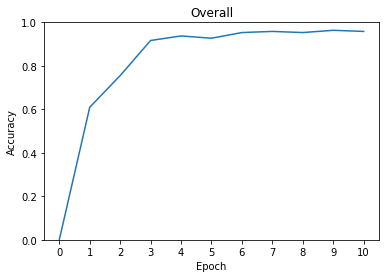

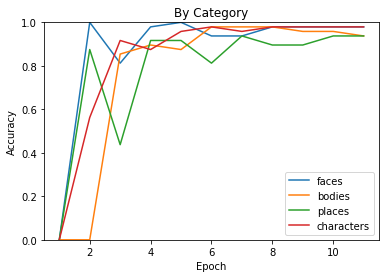

In [60]:
# plot the results for the network without lesions as a sanity check 

epoch = epoch_overall.epoch[1:12]
accuracy = epoch_overall.accuracy[1:12]

plt.plot(epoch, accuracy)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Overall')
plt.ylim(0, 1)

# plot the results by category 

# first transpose data frame to make it easier work with
df = pd.DataFrame(epoch_by_label)
df = df.T
header_row = 0
df.columns = df.iloc[header_row]
df = df.reset_index(drop=True)
df = df.drop(header_row)
df = df.reset_index(drop=True)

# now we will plot accuracy by epoch for each category 
labels = ["faces","bodies","places","characters"]

fig, ax = plt.subplots()
for i in labels:
    epoch = [*range(1,12,1)] # epochs on x axis 
    accuracy = df[i][1:12] # ignore untrained for now 
    ax.plot(epoch,accuracy)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('By Category')
    ax.set_ylim(0, 1)
    ax.legend()
    

Next, we lesioned our network by randomly lesioning 20% of each layer at each epoch. 

In [4]:
# wrangle lesion data so that it's easier to plot.  

lesion_overall = pd.DataFrame(columns=['layer', 'accuracy', 'epoch'],dtype=float)

for i in range(11):
    epoch_overall = pd.read_csv('../results/lesion_exp_overall_epoch_'+str(i)+'.csv')
    # first transpose data frame to make it easier work with
    df = pd.DataFrame(epoch_overall)
    df = df.T
    header_row = 0
    df.columns = df.iloc[header_row]
    df = df.reset_index(drop=True)
    df = df.drop(header_row)
    df = df.reset_index(drop=True)
    df = pd.melt(df)
    df['epoch'] = i
    df = df.rename(columns={"Unnamed: 0": "layer", "value": "accuracy"})
    lesion_overall = lesion_overall.append(df, ignore_index=True)
    
lesion_overall = lesion_overall.astype({'layer': object, 
                'accuracy': float,
                'epoch':int
               } ) 

In [5]:
# wrangle lesion data by category so that it's easier to plot. 
labels = ["faces","bodies","places","characters"]
layers = ["model.features.0","model.features.3","model.features.6","model.features.8","model.features.10"]

data = []
for i in range(11): #epochs 
    epoch = pd.read_pickle("../results/lesion_exp_category_epoch_"+str(i)+".pkl")
    for j in range(10): #experiments 
        exp = epoch["exp_"+str(j)]
        for k in range(5): # layers 
            layer = exp[k]
            for l in labels: # labels 
                accuracy = layer[l]
                data.append([i,j,layers[k],l,accuracy])

lesion_by_cat = pd.DataFrame(data, columns=['epoch', 'exp', 'layer','label','accuracy'])                

We wanted to compare perfomance for each category to performance on the non-lesioned network (black outlines). Overall, face classification was impacted the most and body classification was impacted the least. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


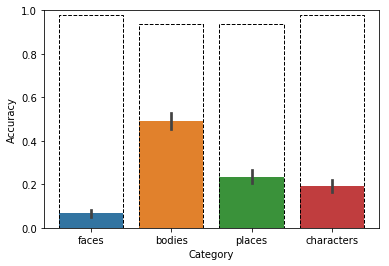

In [13]:
ax = sns.barplot(x="label",y="accuracy", data=lesion_by_cat)
ax.set(ylim = (0,1))
ax.set(xlabel='Category', ylabel='Accuracy')
ax.set(ylim = (0,1))

df = pd.DataFrame(epoch_by_label)
df = df.T
header_row = 0
df.columns = df.iloc[header_row]
df = df.reset_index(drop=True)
df = df.drop(header_row)
df = df.reset_index(drop=True)

labels = ["faces","bodies","places","characters"]
accuracy = []
for l in labels:
    accuracy.append(df[l][11]) #accuracy on the fully trained network 
    
ax.axes.bar(labels,accuracy, fill=0, edgecolor="k",linestyle="--")

plt.show()

Next, we wanted to check whether lesioning the weights at different epochs would affect classification differently for different categories (suggesting different onset of category selectivity). Here it seems that face classification was heavily impacted by lesions at every epoch. Body classification was less impacted than the other categories. Place classification was most impacted by lesions at the early epochs, and character classification was most affected by lesions at epochs 3-7. The dashed line indicates mean classification accuracy in the network lesioned at each epoch (not separated out by category). 

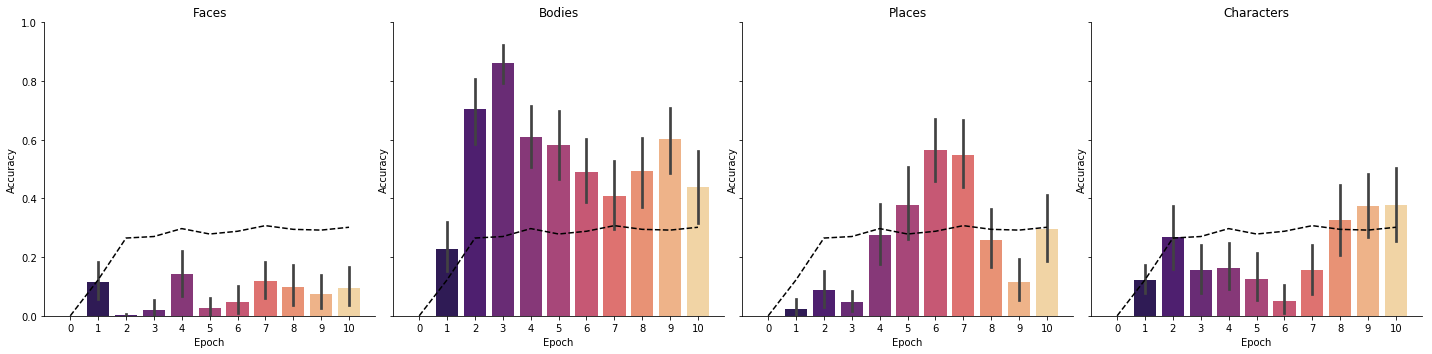

In [7]:
ax = sns.catplot(
    data=lesion_by_cat, x="epoch", y="accuracy",
    col="label", palette="magma",kind="bar")
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.set(ylim = (0,1))

mean_by_epoch = lesion_by_cat.groupby(['epoch']).mean()
mean_by_epoch = mean_by_epoch.accuracy

labels = ["faces","bodies","places","characters"]
axes = ax.axes.flatten()

df = pd.DataFrame(epoch_by_label)
df = df.T
header_row = 0
df.columns = df.iloc[header_row]
df = df.reset_index(drop=True)
df = df.drop(header_row)
df = df.reset_index(drop=True)
    
for i in range(0,4):
    ax.axes[0][i].plot([*range(0,11,1)], mean_by_epoch, 'k--')
   # ax.axes[0][i].plot([*range(0,11,1)], df[labels[i]][1:12], 'k')
    axes[i].set_title(str.capitalize(labels[i]))   

plt.show()

We also wanted to check to see how lesioning affected categorical classifcation at each epoch. The black outline shows performace on the un-lesioned network at each epoch. The colored bars depict the classsification performance of each category lesioned at each epoch. 

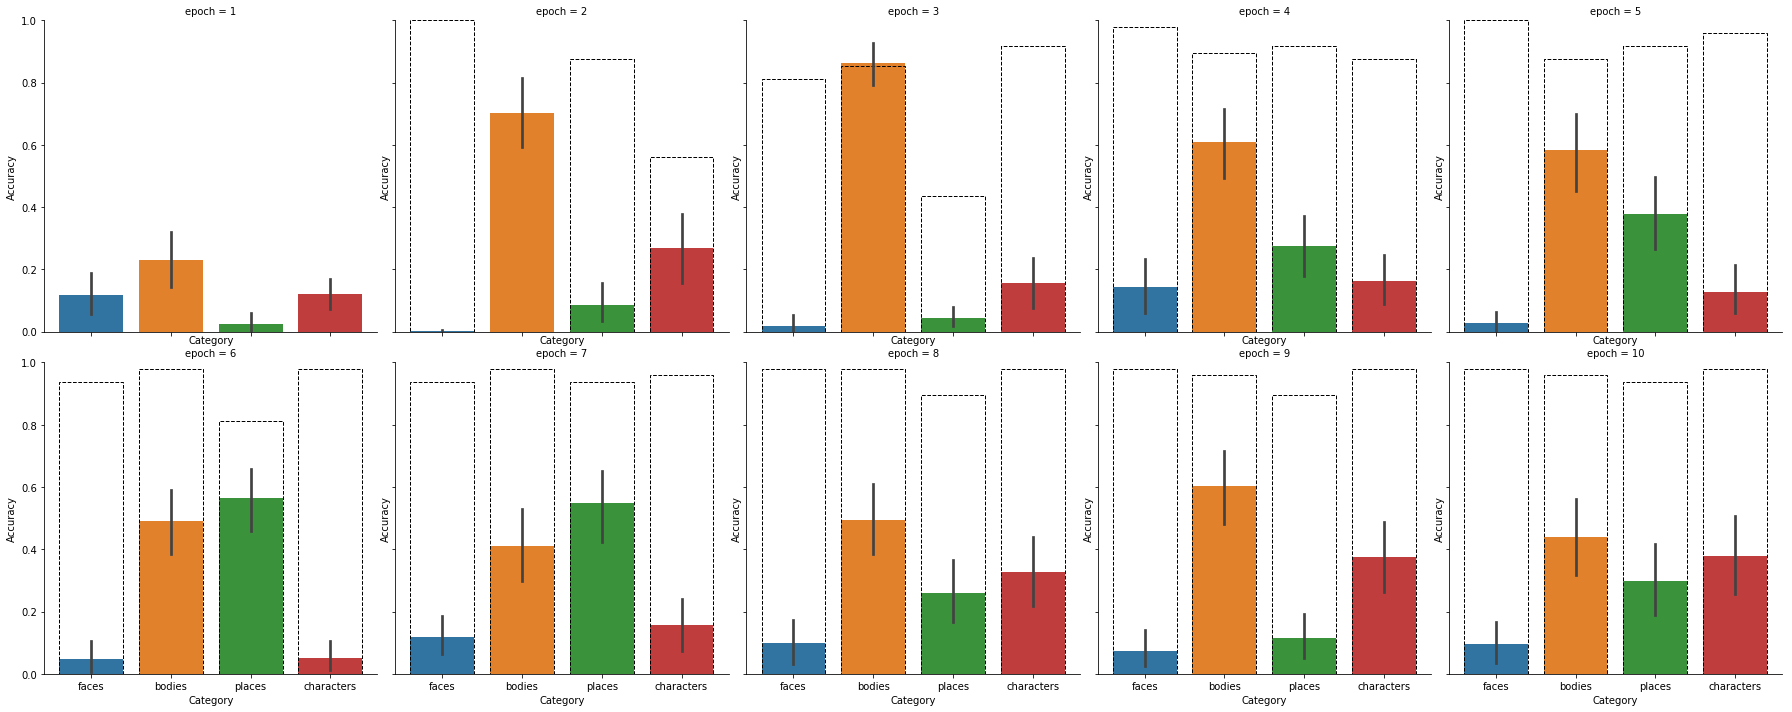

In [53]:
ax = sns.catplot(
    data=lesion_by_cat_no_epoch_0, x="label", y="accuracy",
    col="epoch",kind="bar",col_wrap = 5)
ax.set(xlabel='Category', ylabel='Accuracy')
ax.set(ylim = (0,1))
                     
df = pd.DataFrame(epoch_by_label)
df = df.T
header_row = 0
df.columns = df.iloc[header_row]
df = df.reset_index(drop=True)
df = df.drop(header_row)
df = df.reset_index(drop=True)

axes = ax.axes.flatten()
labels = ["faces","bodies","places","characters"]
for e in range(0,10):  
    accuracy = []
    for l in labels:
        accuracy.append(df[l][e+1]) #accuracy on the fully trained network 
    ax.axes[e].bar(labels,accuracy, fill=0, edgecolor="k",linestyle="--")
    

                     

Finally, we wanted to see whether category classification was impacted differentially by lesions at different layers. The most notable finding is that face classification seems to be distributed across the layers. In other words, lesions to each convolutional layer affected classification of faces. Body classification seems to be paricularly resilient to lesions at layers 3-6. Place and character classification was more affected by lesions in convolutional layers 4-5 than layers 1-2. The dashed line indicates the mean classification accuracy for each convolutional layer (with lesions) not separated out by category.

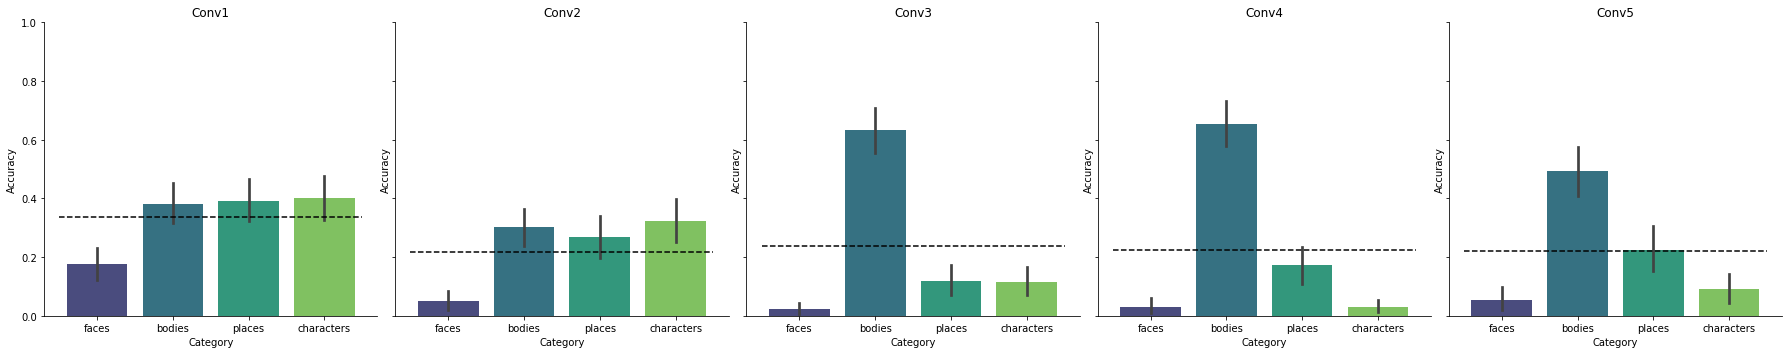

In [8]:
ax = sns.catplot(
    data=lesion_by_cat, x="label", y="accuracy",
    col="layer", palette="viridis",kind="bar")
ax.set(xlabel='Category', ylabel='Accuracy')
ax.set(ylim = (0,1))

layers = ["Conv1","Conv2","Conv3","Conv4","Conv5"]
axes = ax.axes.flatten()
mean_by_layer = lesion_by_cat.groupby(['layer']).mean()
mean_by_layer = mean_by_layer.accuracy


for i in range(0,5):
    axes[i].set_title(layers[i])
    y= np.matlib.repmat(mean_by_layer[i], 2,1)
    ax.axes[0][i].plot((-.5,3.5),y,'k--')

plt.show()